In [43]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
#from tqdm import tqdm_notebook
#tqdm_notebook().pandas(*args, **kwargs)

In [6]:
%%time

train = pd.read_csv('data/bms-molecular-translation/train_labels.csv')
test = pd.read_csv('data/bms-molecular-translation/sample_submission.csv')

display(train.head())
display(test.head())

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


CPU times: user 4.39 s, sys: 392 ms, total: 4.78 s
Wall time: 4.81 s


In [7]:
def get_train_file_path(image_id):
    return "data/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

def get_test_file_path(image_id):
    return "data/bms-molecular-translation/test/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )


In [31]:
train['file_path'] = train['image_id'].progress_apply(get_train_file_path)
test['file_path'] = test['image_id'].progress_apply(get_test_file_path)

print(f'train.shape: {train.shape}  test.shape: {test.shape}')

2424186it [00:36, 66461.73it/s] 


train.shape: (2424186, 7)  test.shape: (1616107, 3)


In [10]:
display(train.head())
display(test.head())

,image_id,InChI,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,data/bms-molecular-translation/train/0/0/0/000...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,data/bms-molecular-translation/train/0/0/0/000...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,data/bms-molecular-translation/train/0/0/0/000...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,data/bms-molecular-translation/train/0/0/0/000...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,data/bms-molecular-translation/train/0/0/0/000...


,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
1,00001f7fc849,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
2,000037687605,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
3,00004b6d55b6,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
4,00004df0fe53,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...


## Move forward only with train
### Clean InChI-tag

In [13]:
def clean_InChI(inchi):
    inchi = inchi.replace(" ", "")
    return inchi

In [14]:
train["InChI_clean"] = train.InChI.apply(clean_InChI)

In [17]:
train.InChI_clean.unique().shape

(2424186,)

This shows, that all InChI are different, no small class numbers. That means, that this may be less of a classification task and more a translation from image to the three_parts of InChI. Next split InChI into its parts (separated by "/") and have a look at them.

In [34]:
def split_InChI(row):
    s = row["InChI_clean"].replace("InChI=", "").split("/")
    #if len(s) != 3:
    #    print("InChI is different: {}".format(row["InChI_clean"]))
    
    
    row["InChI_1"] = s[0]
    row["InChI_2"] = s[1]
    row["InChI_3"] = "/".join(s[2:])
    return row
    #return s[0], s[1], "/".join(s[2:])

In [35]:
#train[["InChI_1", "InChI_2", "InChI_3"]] = train.apply(split_InChI, axis=1)
train = train.progress_apply(split_InChI, axis=1)

100%|██████████| 2424186/2424186 [02:28<00:00, 16337.33it/s]


In [36]:
train.head()

,image_id,InChI,file_path,InChI_clean,InChI_1,InChI_2,InChI_3
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,data/bms-molecular-translation/train/0/0/0/000...,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,1S,C13H20OS,"c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9..."
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,data/bms-molecular-translation/train/0/0/0/000...,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,1S,C21H30O4,c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,data/bms-molecular-translation/train/0/0/0/000...,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,1S,C24H23N5O4,c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,data/bms-molecular-translation/train/0/0/0/000...,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,1S,C17H24N2O4S,c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,data/bms-molecular-translation/train/0/0/0/000...,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,1S,C10H19N3O2S,"c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,..."


In [39]:
train.InChI_1.unique().shape

(1,)

So the first part ("1S") is always the same. We do not have to classify this.

Second part:

In [40]:
train.InChI_2.unique().shape

(329768,)

In our 2.4m samples we have ±0.33m different part 2s

<AxesSubplot:ylabel='Frequency'>

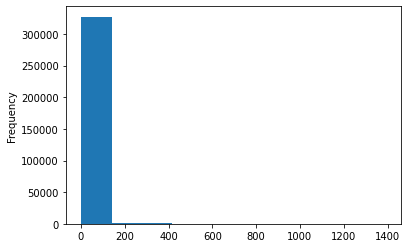

In [44]:
train.groupby("InChI_2").InChI_2.count().plot(kind="hist")

most of the classes appear only a small number of times. Let's look at the most frequent classes:

In [49]:
train.groupby("InChI_2").InChI_2.count().sort_values(ascending=False)

InChI_2
C15H22N2O2      1391
C16H24N2O2      1312
C14H20N2O2      1214
C17H26N2O2      1102
C14H22N2O2      1065
                ... 
C22H11ClN2O5       1
C22H11ClN2OS       1
C22H11ClN4O2       1
C22H11ClN6O2       1
Cl8H2N5O2P5        1
Name: InChI_2, Length: 329768, dtype: int64

The most frequent class (C15H22N2O2) appears 1391 times. It is no that much, but 1391 times as much as all the classes, that appear only one time.
Majority vote: 1391/2424186 = 0.06%

Third part:

In [51]:
train.InChI_3.unique().shape

(2412183,)

Almost all samples have a different part 3. Let's look at the part 3s of the most frequent part 2:

In [56]:
train[train["InChI_2"]=="C15H22N2O2"].InChI_3.unique().shape

(1391,)

All these samples have different part 3s. Maybe part 2 and 3 has to be modelled character-wise, because 0.33m and 2.4m classes are too much with a dataset of 2.4m samples

In [59]:
list("C15H22N2O2")

['C', '1', '5', 'H', '2', '2', 'N', '2', 'O', '2']

In [97]:
def extract_atoms(s):
    result = {}
    atom = ""
    count = 0
    for c in s:
        try:
            count = 10 * count + int(c)
        except ValueError:
            if count == 0:
                if c.islower():
                    atom = atom + c
                else:
                    result[atom] = 1
                    count = 0
                    atom = c
            elif atom != "":
                result[atom] = count
                count = 0
                atom = c
    result[atom] = count
    return result

In [100]:
def extract_sequence(s):
    result = []
    atom = ""
    for c in s:
        try:
            int(c)
            if atom != "":
                result.append(atom)
                atom = ""
        except ValueError:
            if c.islower():
                atom = atom + c
            else:
                if atom != "":
                    result.append(atom)
                atom = c
    if atom != "":
        result.append(atom)
    return result

In [74]:
extract_atoms("C15Hh22N2O2")

{'C': 15, 'Hh': 22, 'N': 2, 'O': 2}

In [78]:
extract_sequence("C15Hh22N2O2")

['C', 'Hh', 'N', 'O']

In [106]:
def test_sequences(seq1, seq2):
    for element in seq1:
        smaller = seq1[:seq1.index(element)]
        larger = seq1[seq1.index(element)+1:]
        idx = seq2.index(element)
        for item in smaller:
            if seq2.index(item) > idx:
                return False
        for item in larger:
            if seq2.index(item) < idx:
                return False
    return True

def show_wrong_item(seq1, seq2):
    for element in seq1:
        smaller = seq1[:seq1.index(element)]
        larger = seq1[seq1.index(element)+1:]
        idx = seq2.index(element)
        for item in smaller:
            try:
                if seq2.index(item) > idx:
                    return element, "lower", False
            e
        for item in larger:
            try:
                if seq2.index(item) < idx:
                    return element, "larger", False
            except ValueError:
                pass
    return "", "", True

In [84]:
test_sequences(["a", "f", "d"], ["a", "b", "c", "d", "f"])

False

In [90]:
def reorder(sequence, element, direction):
    idx = order.index(element)
    if direction == "larger":
        order[idx], order[idx+1] = order[idx+1], order[idx]
    elif direction == "lower":
        order[idx], order[idx-1] = order[idx-1], order[idx]

In [101]:
sequences = train.InChI_2.progress_apply(extract_sequence)

100%|██████████| 2424186/2424186 [00:17<00:00, 136476.54it/s]


In [104]:
sequences = sequences.to_list()

In [113]:
order = ["C"]
for sequence in tqdm(sequences):
    for element in sequence:
        if element not in order:
            order.append(element)
            
    element, changement, iterate = show_wrong_item(order, sequence)
    while not iterate:
        reorder(order, element, changement)
        element, changement, iterate = show_wrong_item(order, sequence)

  0%|          | 1/2424186 [00:00<03:59, 10106.76it/s]


ValueError: 'S' is not in list

In [125]:
order = sequences[0]

In [142]:
sequence = sequences[3]

In [143]:
sequence

['C', 'H', 'N', 'O', 'S']

In [136]:
for element in sequence:
        if element not in order:
            order.append(element)

In [139]:
element, changement, iterate = show_wrong_item(order, sequence)
while not iterate:
    reorder(order, element, changement)
    element, changement, iterate = show_wrong_item(order, sequence)

In [140]:
sequence

['C', 'H', 'N', 'O']

In [141]:
order

['C', 'H', 'S', 'N', 'O']

In [144]:
sequences[0]

['C', 'H', 'S', 'N', 'O']

Long story short: the order of the elements is not defined, meaning S does not always come before O and N

This means, we cannot train a model, that outputs just the number of each element and construct the string out of that information

In [145]:
sequences

[['C', 'H', 'S', 'N', 'O'],
 ['C', 'H', 'O'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'Br', 'N', 'O'],
 ['C', 'H', 'Br', 'N', 'O'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'Br', 'N', 'O'],
 ['C', 'H', 'Br', 'F', 'N', 'O', 'S'],
 ['C', 'H', 'F', 'N', 'S'],
 ['C', 'H', 'N', 'S'],
 ['C', 'H', 'O'],
 ['C', 'H', 'Cl', 'N', 'O'],
 ['C', 'H', 'N', 'S'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'O'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'Cl', 'N', 'O'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'O'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'Br', 'Cl', 'N', 'S'],
 ['C', 'H', 'O', 'S'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'N'],
 ['C', 'H', 'F', 'N', 'O'],
 ['C', 'H', 'N'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'O'],
 ['C', 'H', 'N', 'O'],
 ['C', 'H', 'Br', 'F', 'N', 'O'],
 ['C', 'H', 'Cl', 'N', 'O'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O', 'S'],
 ['C', 'H', 'N', 'O'],
 ['